Testing the tactile gym

In [1]:
from tactile_gym.rl_envs.demo_rl_env_base import demo_rl_env
from tactile_gym.rl_envs.exploration.edge_follow.edge_follow_env import EdgeFollowEnv
from scipy import signal
from scipy import misc

import numpy as np
import copy
import cv2
import matplotlib.pyplot as plt
import cv2 as cv
import torch
import random as rnd
from IPython.display import clear_output 

/usr/local/lib/python3.8/dist-packages/gym-0.21.0-py3.8.egg/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment ALE/Tetris-v5
  logger.warn("Overriding environment {}".format(id))
/usr/local/lib/python3.8/dist-packages/gym-0.21.0-py3.8.egg/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment ALE/Tetris-ram-v5
  logger.warn("Overriding environment {}".format(id))
/usr/local/lib/python3.8/dist-packages/gym-0.21.0-py3.8.egg/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment Adventure-v0
  logger.warn("Overriding environment {}".format(id))
/usr/local/lib/python3.8/dist-packages/gym-0.21.0-py3.8.egg/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment AdventureDeterministic-v0
  logger.warn("Overriding environment {}".format(id))
/usr/local/lib/python3.8/dist-packages/gym-0.21.0-py3.8.egg/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment AdventureNoFrameskip-v0
  logger.warn("Overriding env

First we set up some variables of what we want within the envirnment. 

Number of iterations is how long our training loop will be

max_steps is how many steps each iteration can ake within the environment

show_gui allows us to view or not view a gui showing whats going on

This is the same with show tactle

Rendering is required for showing the gui - it is quicker without



In [2]:

seed = int(0)
num_iter = 100
max_steps = 250
show_gui = True
show_tactile = True
render = True
print_info = False
image_size = [128, 128]


Set up the environment

In [3]:
env_modes = {
    # which dofs can have movement
    "movement_mode": "xy",

    # specify arm
    "arm_type": "ur5",

    # specify tactile sensor
    "tactile_sensor_name": "tactip",
    # "tactile_sensor_name": "digit",
    # "tactile_sensor_name": "digitac",

    # the type of control used
    # "control_mode": "TCP_position_control",
    'control_mode': 'TCP_velocity_control',

    # add variation to embed distance to optimise for
    # warning, don't use rand height when controlling z unless
    # including embed distance in observation
    # 'noise_mode':'fixed_height',
    "noise_mode": "rand_height",

    # which observation type to return
    'observation_mode': 'oracle',
    "observation_mode": "tactile",
    # 'observation_mode':'visual',
    # 'observation_mode':'visuotactile',

    # which reward type to use (currently only dense)
    "reward_mode": "dense"
    # 'reward_mode':'sparse'
}
env = EdgeFollowEnv(
    max_steps=max_steps,
    env_modes=env_modes,
    show_gui=show_gui,
    show_tactile=show_tactile,
    image_size=image_size
)

# set seed for deterministic results
env.seed(seed)
env.action_space.np_random.seed(seed)


argv[0]=
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=3
argv[0] = --unused
argv[1] = 
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro P620/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 525.78.01
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 525.78.01
Vendor = NVIDIA Corporation
Renderer = Quadro P620/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


Activate GUI is selected

In [4]:
# create controllable parameters on GUI
action_ids = []
min_action = env.min_action
max_action = env.max_action
if show_gui:

    if env_modes["movement_mode"] == "xy":
        action_ids.append(env._pb.addUserDebugParameter("dX", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dY", min_action, max_action, 0))

    elif env_modes["movement_mode"] == "xyz":
        action_ids.append(env._pb.addUserDebugParameter("dX", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dY", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dZ", min_action, max_action, 0))

    elif env_modes["movement_mode"] == "xyRz":
        action_ids.append(env._pb.addUserDebugParameter("dX", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dY", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dRz", min_action, max_action, 0))

    elif env_modes["movement_mode"] == "xyzRz":
        action_ids.append(env._pb.addUserDebugParameter("dX", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dY", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dZ", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dRz", min_action, max_action, 0))

# run the control loop
#demo_rl_env(env, num_iter, action_ids, show_gui, show_tactile, render, print_info)

Make model for evolution, this uses a convolutional neural network. Weights are assigned randomly.

In [22]:
class Agent_Conv2D:
    def __init__(self, num_input, layers, num_output):
        assert type(layers)==type([]), "Error with layers, give array of the number of layers"
        self.num_input = num_input  #set input number
        self.num_output = num_output #set ooutput number
        self.hidden=[]
        last=num_input
        self.num_genes=0
        for layer in layers:
            self.hidden.append(layer)
            self.num_genes+=(last * layer)
            last=layer
        self.num_genes +=(self.hidden[-1]*num_output)+num_output
        self.weights = None
        self.hidden_weights=None
        self.bias = None
        print("Auto",self.num_genes)
    def set_genes(self, gene):
        weight_idxs = self.num_input * self.hidden[0] #size of weights to hidden
        current=weight_idxs
        weights_idxs=[current] #start with end of last
        for i in range(len(self.hidden)-1):
            current+=self.hidden[i]*self.hidden[i+1] #calculate next idx for each layer
            weights_idxs.append(current)
        bias_idxs=None
        weights_idxs.append(self.hidden[-1] * self.num_output + weights_idxs[-1]) #add last layer heading to output
        bias_idxs = weights_idxs[-1]+ self.num_output #sizes of biases
        w = gene[0 : weight_idxs].reshape(self.hidden[0], self.num_input)   #merge genes
        ws=[]
        for i in range(len(self.hidden)-1):
            ws.append(gene[weights_idxs[i] : weights_idxs[i+1]].reshape(self.hidden[i+1], self.hidden[i]))
        ws.append(gene[weights_idxs[-2] : weights_idxs[-1]].reshape(self.num_output, self.hidden[-1]))
        b = gene[weights_idxs[-1]: bias_idxs].reshape(self.num_output,) #merge genes

        self.weights = torch.from_numpy(w) #assign weights
        self.hidden_weights=[]
        for w in ws:
            self.hidden_weights.append(torch.from_numpy(w))
        self.bias = torch.from_numpy(b) #assign biases

    def forward(self, x):
        #create conv layer
        scharr = np.array([[ -3-3, 0-10,  +3 -3],
                   [-10+0, 0+ 0, +10 +0],
                   [ -3+3, 0+10,  +3 +3]]) # Gx + j*Gy
        x= signal.convolve2d(x, scharr, boundary='symm', mode='same')   
        x=x.flatten()
        x=torch.tensor(x[:,np.newaxis]).float()  
        #x = torch.tensor(np.dot(self.weights.float(),x).flatten()).float()
        #run through forward layers
        x = torch.mm(x.T, self.weights.T.float()) #first layer

        for i in range(len(self.hidden_weights)-1):
            x = torch.mm(x,self.hidden_weights[i].T.float()) #second layer
        x=torch.sigmoid(x)
        return torch.mm(x,self.hidden_weights[-1].T.float()) + self.bias #third layer
    
    def get_action(self, x):
        vectors=[(1,1),(1,0),(0,1),(-1,-1),(-1,0),(0,-1),(-1,1),(1,-1),(0,0)] #possible moves
        arr=self.forward(x)[0]
        ind=np.argmax(arr)
        return np.array(vectors[ind])
    
class Agent:
    def __init__(self, num_input, layers, num_output):
        assert type(layers)==type([]), "Error with layers, give array of the number of layers"
        self.num_input = num_input  #set input number
        self.num_output = num_output #set ooutput number
        self.hidden=[]
        last=num_input
        self.num_genes=0
        for layer in layers:
            self.hidden.append(layer)
            self.num_genes+=(last * layer)
            last=layer
        self.num_genes +=(self.hidden[-1]*num_output)+num_output
        self.weights = None
        self.hidden_weights=None
        self.bias = None
        print("Auto",self.num_genes)
    def set_genes(self, gene):
        weight_idxs = self.num_input * self.hidden[0] #size of weights to hidden
        current=weight_idxs
        weights_idxs=[current] #start with end of last
        for i in range(len(self.hidden)-1):
            current+=self.hidden[i]*self.hidden[i+1] #calculate next idx for each layer
            weights_idxs.append(current)
        bias_idxs=None
        weights_idxs.append(self.hidden[-1] * self.num_output + weights_idxs[-1]) #add last layer heading to output
        bias_idxs = weights_idxs[-1]+ self.num_output #sizes of biases
        w = gene[0 : weight_idxs].reshape(self.hidden[0], self.num_input)   #merge genes
        ws=[]
        for i in range(len(self.hidden)-1):
            ws.append(gene[weights_idxs[i] : weights_idxs[i+1]].reshape(self.hidden[i+1], self.hidden[i]))
        ws.append(gene[weights_idxs[-2] : weights_idxs[-1]].reshape(self.num_output, self.hidden[-1]))
        b = gene[weights_idxs[-1]: bias_idxs].reshape(self.num_output,) #merge genes

        self.weights = torch.from_numpy(w) #assign weights
        self.hidden_weights=[]
        for w in ws:
            self.hidden_weights.append(torch.from_numpy(w))
        self.bias = torch.from_numpy(b) #assign biases

    def forward(self, x):
        x=x.flatten()
        x=torch.tensor(x[:,np.newaxis]).float()  
        #x = torch.tensor(np.dot(self.weights.float(),x).flatten()).float()
        #run through forward layers
        x = torch.mm(x.T, self.weights.T.float()) #first layer

        for i in range(len(self.hidden_weights)-1):
            x = torch.mm(x,self.hidden_weights[i].T.float()) #second layer
        x=torch.sigmoid(x)
        return torch.mm(x,self.hidden_weights[-1].T.float()) + self.bias #third layer
    
    def get_action(self, x):
        vectors=[(1,1),(1,0),(0,1),(-1,-1),(-1,0),(0,-1),(-1,1),(1,-1),(0,0)] #possible moves
        arr=self.forward(x)[0]
        ind=np.argmax(arr)
        return np.array(vectors[ind])

create an agent and population of genes

In [215]:
DIM=25
sensor=Agent_Conv2D(DIM*DIM,[100,60,30],9)
#sensor=Agent(DIM*DIM,100,60,30],8)
size=sensor.num_genes
def gen_population(pop_size=25):
    population=np.random.normal(0,3,(pop_size,size))
    return population
"""for i in range(pop_size):
    population[i]+=(size))"""

print(gen_population()[0])
population=gen_population()

Auto 70579
[-1.081985 -0.595011 -4.608640 ... 1.902842 3.824630 0.871107]


Fitness function and mutation of genes

In [212]:
MASTER = cv2.imread("/its/home/drs25/Pictures/good.png")
MASTER = cv2.cvtColor(MASTER, cv2.COLOR_BGR2GRAY)
MASTER = cv2.resize(MASTER, dsize=(DIM,DIM), interpolation=cv2.INTER_AREA) #rescale

def get_similarity(img1,img2):
    img1[img1>0]=255
    img2[img2>0]=255
    diff = cv2.absdiff(img1, img2) 
    return (1-(np.sum(diff))/(DIM*DIM*255*0.24) )

def new_fitness(tactile):
    if np.sum(tactile)==0: return 0
    return get_similarity(MASTER,tactile)
    
def fitness(tactile):
    #lets say we want to maximize the lighter pixels 
    all=np.sum(tactile)
    all=(all)/(DIM*DIM*255)
    return all
def mutation(gene, mean=0, std=0.5,size=400):
    assert size<len(gene)
    n=rnd.randint(0,len(gene)-size-1)
    array=np.random.normal(mean,std,size=size)
    gene = gene[n:n+size] + array #mutate the gene via normal 
    # constraint
    gene[gene >4] = 4
    gene[gene < -4] = -4
    return gene

def crossover(loser, winner, p_crossover=0.5): #provide a crossover function
    for i,gene in enumerate(winner):
      if rnd.random() <= p_crossover:
        loser[i] = winner[i]
    return loser

show what agent sees

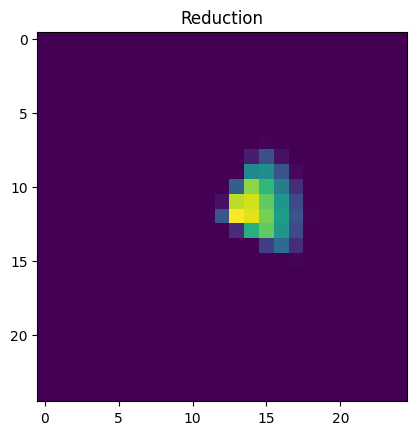

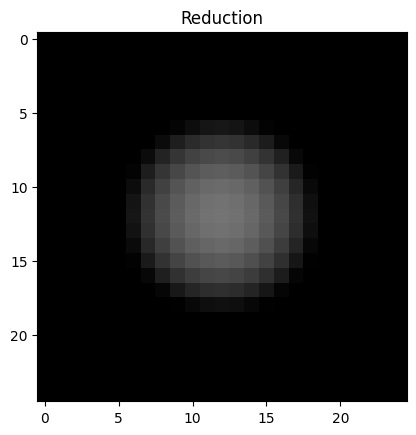

1.0 0.2666666666666667


In [213]:
o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0
tactile_input=np.reshape(o['tactile'],(128,128))
tactile_input=cv2.resize(tactile_input, dsize=(DIM,DIM), interpolation=cv2.INTER_AREA) #rescale

plt.title("Reduction")
#tactile_input[tactile_input>0]=255
plt.imshow(tactile_input)
plt.show()

img1 = cv2.imread("/its/home/drs25/Pictures/good.png")
img1 = cv2.resize(img1, dsize=(DIM,DIM), interpolation=cv2.INTER_AREA) #rescale

plt.title("Reduction")
plt.imshow(img1)
plt.show()

print(new_fitness(MASTER),new_fitness(tactile_input))
blank=np.zeros((DIM,DIM), dtype=np.uint8)


Applying the microbial GA algorithm

In [216]:
def run_trial(sensor,gene,max_t,save=None):
    dt=0.1
    t=0
    done=False
    r_sum = 0
    o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0
    step = 0
    sensor.set_genes(gene) #set the gene of the robot
    while not done and t<=max_t: #loop till sturdy or out of time
        tactile_input=np.reshape(o['tactile'],(128,128))
        tactile_input=cv2.resize(tactile_input, dsize=(DIM,DIM), interpolation=cv2.INTER_AREA) #rescale
        tactile_input[tactile_input>0]=1
        a=sensor.get_action(tactile_input) #push through tactile input into agent
        # step the environment
        o, r, d, info = env.step(a) #step through environment
        #print(a,env.action_space.sample())
        fit=new_fitness(tactile_input)
        if fit==0: 
            r_sum=0
            done=True #end if lost
        r_sum +=fit*(2**round(t)) #the reward becomes more important over time
        #if fit>=0.5: done=True #if it is sturdy
        t+=dt #increase by timestep
        if save!=None: save.append(env.render())
    return r_sum, env.render() #we care about the last fitnesses as it should be sturdy

def run_microbial(sensor,population,generations): #microbial algorithm trial
    fitnesses=[0]
    rendered=[]
    bestInd=-1
    r1=None
    r2=None
    f1=0
    try:
        for i in range(generations):
            clear_output()
            print("GEN: ",i,"REWARD: ",fitnesses[-1],str(f1/3))
            try:
                plt.title("Best at epoch")
                plt.imshow(rendered[-1])
                plt.show()
            except:
                pass
            #select neighbouring genes
            ind_1 = rnd.randint(0,len(population)-1)
            ind_2=ind_1+1
            if ind_2 >= len(population): ind_2=ind_1-1
            #get two random positions
            gene1=population[ind_1]
            gene2=population[ind_2]
            #run trials for 20 seconds in sim time
            f1=0
            r=None
            for i in range(3): #run 3 trials to make sure there is no fluke
                f,r=run_trial(sensor,gene1,3)
                if f>f1/(i+1): r1=copy.deepcopy(r)
                f1+=f
            fit1=f1/3 #get average performance
            f2=0
            for i in range(3): #run 3 trials for fluke
                f,r=run_trial(sensor,gene2,3)
                if f>f2/(i+1): r2=copy.deepcopy(r)
                f2+=f
            fit2=f2/3
            if fit1>fitnesses[-1] and fit1<fit2: 
                rendered.append(r1)
                bestInd=ind_1
            elif fit2>fitnesses[-1]:
                rendered.append(r2)
                bestInd=ind_2
            fitnesses.append(max([fitnesses[-1],fit1,fit2]))
            #selection
            if fit1>fit2:
                gene2=copy.deepcopy((gene1)) #crossover
                population[ind_2]=copy.deepcopy(crossover(gene2,mutation(gene1)))
            elif fit2>fit1:
                gene1=copy.deepcopy((gene2)) #crossover
                population[ind_1]=copy.deepcopy(crossover(gene1,mutation(gene2)))
    except KeyboardInterrupt:
        pass
            
    return fitnesses, rendered, bestInd


GEN:  299 REWARD:  71.76666666666667 32.18666666666667


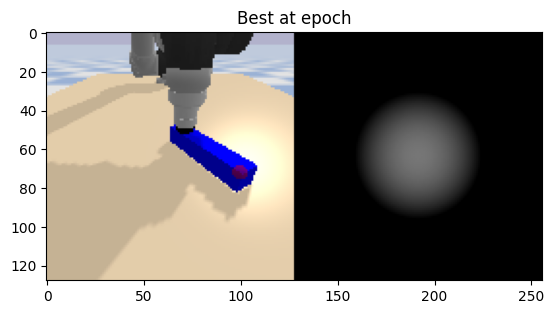

In [217]:
GENERATIONS=300
pop=gen_population()
f,r,ind=run_microbial(sensor,pop,GENERATIONS)

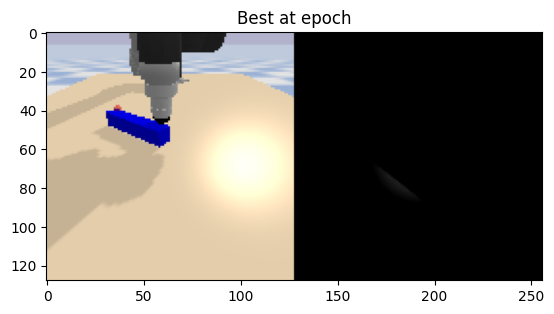

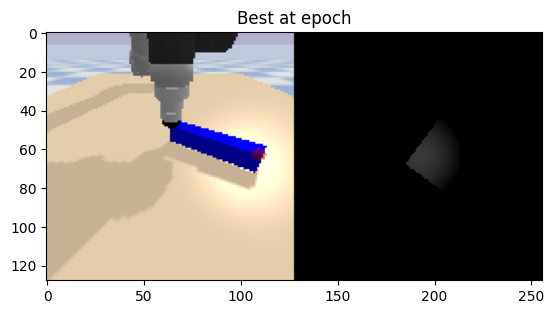

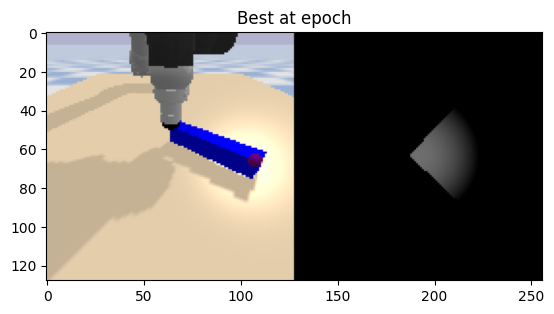

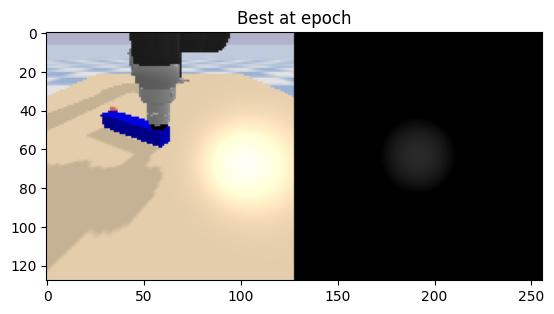

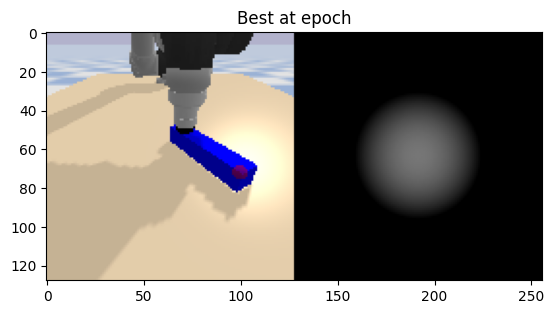

In [218]:

#print(len(r),r)
for i in range(0,len(r),1 if len(r) < 10 else int(len(r)/10)):
    plt.title("Best at epoch")
    plt.imshow(r[i])
    plt.show()


What live demo of the best genotype

In [219]:

arr=[]
best=0
best_ind=0
for ind in range(len(pop)):
    arr_=[]
    f,r=run_trial(sensor,pop[ind],3,save=arr_)
    if f>best:
        best=f
        best_ind=ind
        arr=copy.deepcopy(arr_)


In [220]:
arr=[]
f,r=run_trial(sensor,pop[best_ind],15,save=arr)


In [221]:
o, r, d, info = env.step(np.array([0,0])) #step through environment
tactile = o['tactile']
if np.sum(tactile)==0: print("blank")
sensor.set_genes(population[0])
a=sensor.get_action(tactile_input) #push through tactile input into agent
a

array([1, 1])

Saving the demo

In [222]:
import cv2 as cv
h,w=arr[0].shape[:2]
out = cv.VideoWriter('./Gym_tactip.avi',cv.VideoWriter_fourcc(*'DIVX'), 10, (w,h))
#gen vid
for i,j in enumerate(arr):
    out.write(j)
out.release()

In [223]:
for i in range(100):
    env.step(np.array([1,0])) #step through environment

Run with 1D nn

GEN:  999 REWARD:  69.45555555555556 44.26


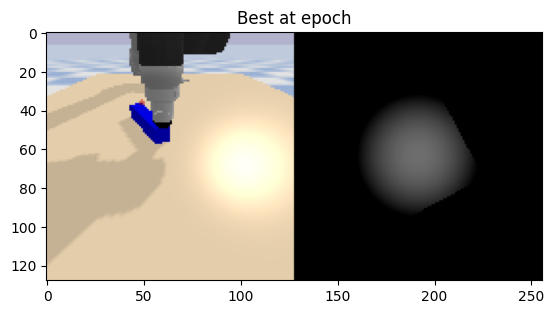

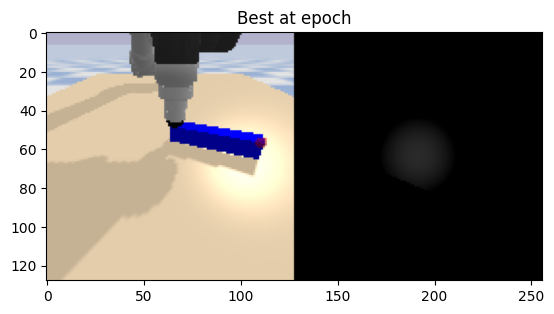

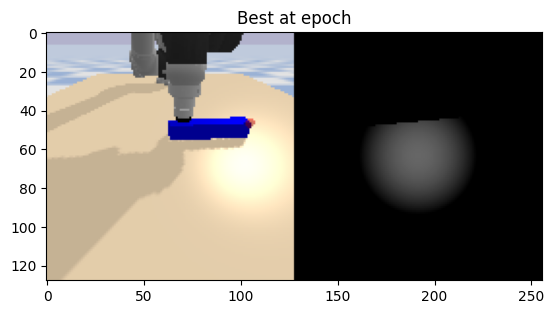

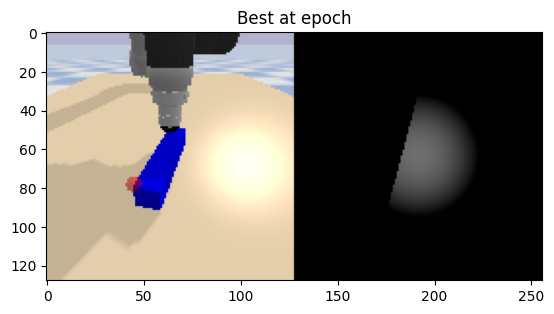

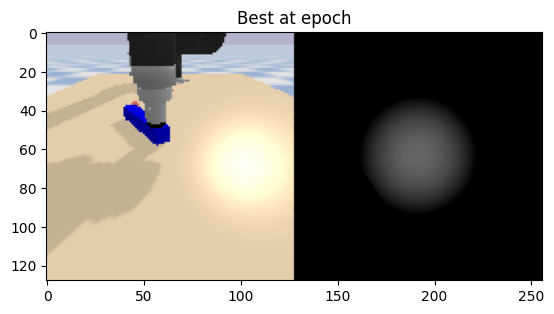

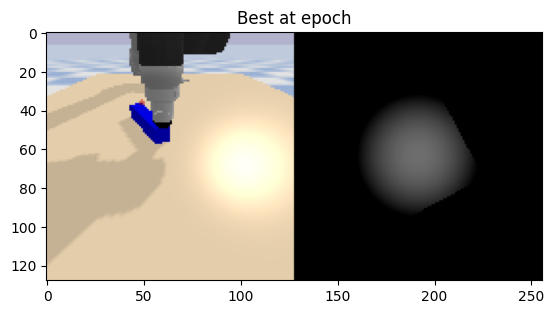

In [224]:
GENERATIONS=1000
sensor=Agent(DIM*DIM,[100,60,30],9)
pop=gen_population()
f,r,ind=run_microbial(sensor,pop,GENERATIONS)

for i in range(0 if len(r)<5 else len(r)-5,len(r),1 if len(r) < 10 else int(len(r)/10)):
    plt.title("Best at epoch")
    plt.imshow(r[i])
    plt.show()
arr=[]
best=0
best_ind=0
for ind in range(len(pop)):
    arr_=[]
    f,r=run_trial(sensor,pop[ind],3,save=arr_)
    if f>best:
        best=f
        best_ind=ind
        arr=copy.deepcopy(arr_)


h,w=arr[0].shape[:2]
arr=[]
f,r=run_trial(sensor,pop[best_ind],10,save=arr)
out = cv.VideoWriter('./Gym_tactip_flat.avi',cv.VideoWriter_fourcc(*'DIVX'), 15, (w,h))
#gen vid
for i,j in enumerate(arr):
    out.write(j)
out.release()

In [225]:
arr=[]
best=0
best_ind=0
for ind in range(len(pop)):
    arr_=[]
    f,r=run_trial(sensor,pop[ind],3,save=arr_)
    if f>best:
        print(ind)
        best=f
        best_ind=ind
        arr=copy.deepcopy(arr_)


h,w=arr[0].shape[:2]
arr=[]
f,r=run_trial(sensor,pop[best_ind],10,save=arr)
out = cv.VideoWriter('./Gym_tactip_flat.avi',cv.VideoWriter_fourcc(*'DIVX'), 5, (w,h))
#gen vid
for i,j in enumerate(arr):
    out.write(j)
out.release()

0
2
3
18
20


In [226]:
h,w=arr[0].shape[:2]
arr=[]
print(best_ind)
f,r=run_trial(sensor,pop[21],15,save=arr)
out = cv.VideoWriter('./Gym_tactip_flat.avi',cv.VideoWriter_fourcc(*'DIVX'), 10, (w,h))
#gen vid
for i,j in enumerate(arr):
    out.write(j)
out.release()

20


# Reinforcement learning approach

In [40]:
from tactile_gym.rl_envs.demo_rl_env_base import demo_rl_env
from tactile_gym.rl_envs.exploration.edge_follow.edge_follow_env import EdgeFollowEnv
from scipy import signal
from scipy import misc

import numpy as np
import copy
import cv2
import matplotlib.pyplot as plt
import cv2 as cv
import torch
# Provides extra neural network functions
import torch.nn as nn
# Provides optimizers
import torch.optim as optim
import random as rnd
from collections import deque 
from IPython.display import clear_output 


In [85]:
seed = int(0)
num_iter = 100
max_steps = 250
show_gui = True
show_tactile = True
render = True
print_info = False
image_size = [128, 128]

env_modes = {
    # which dofs can have movement
    "movement_mode": "xy",

    # specify arm
    "arm_type": "ur5",

    # specify tactile sensor
    "tactile_sensor_name": "tactip",
    # "tactile_sensor_name": "digit",
    # "tactile_sensor_name": "digitac",

    # the type of control used
    # "control_mode": "TCP_position_control",
    'control_mode': 'TCP_velocity_control',

    # add variation to embed distance to optimise for
    # warning, don't use rand height when controlling z unless
    # including embed distance in observation
    # 'noise_mode':'fixed_height',
    "noise_mode": "rand_height",

    # which observation type to return
    'observation_mode': 'oracle',
    "observation_mode": "tactile",
    # 'observation_mode':'visual',
    # 'observation_mode':'visuotactile',

    # which reward type to use (currently only dense)
    "reward_mode": "dense"
    # 'reward_mode':'sparse'
}
env = EdgeFollowEnv(
    max_steps=max_steps,
    env_modes=env_modes,
    show_gui=show_gui,
    show_tactile=show_tactile,
    image_size=image_size
)

# set seed for deterministic results
env.seed(seed)
env.action_space.np_random.seed(seed)
# create controllable parameters on GUI
action_ids = []
min_action = env.min_action
max_action = env.max_action
if show_gui:

    if env_modes["movement_mode"] == "xy":
        action_ids.append(env._pb.addUserDebugParameter("dX", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dY", min_action, max_action, 0))

    elif env_modes["movement_mode"] == "xyz":
        action_ids.append(env._pb.addUserDebugParameter("dX", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dY", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dZ", min_action, max_action, 0))

    elif env_modes["movement_mode"] == "xyRz":
        action_ids.append(env._pb.addUserDebugParameter("dX", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dY", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dRz", min_action, max_action, 0))

    elif env_modes["movement_mode"] == "xyzRz":
        action_ids.append(env._pb.addUserDebugParameter("dX", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dY", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dZ", min_action, max_action, 0))
        action_ids.append(env._pb.addUserDebugParameter("dRz", min_action, max_action, 0))

# run the control loop
#demo_rl_env(env, num_iter, action_ids, show_gui, show_tactile, render, print_info)

argv[0]=
startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=3
argv[0] = --unused
argv[1] = 
argv[2] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=Quadro P620/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 525.78.01
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 525.78.01
Vendor = NVIDIA Corporation
Renderer = Quadro P620/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = NVIDIA Corporation
ven = NVIDIA Corporation


Set up model

In [80]:
class model:
    def __init__(self):
        # Initialize discount and exploration rate
        self.gamma = 0.6
        self.epsilon = 0.1
        #experience
        self.expirience_replay = deque(maxlen=2000)
        #input size be 50*50
        self.input=nn.Parameter(torch.rand(DIM*DIM,100))
        self.h1=nn.Parameter(torch.rand(100,60))
        self.out=nn.Parameter(torch.rand(60,9))
        #target network
        self.target_input=torch.rand(DIM*DIM,100)
        self.target_h1=torch.rand(100,60)
        self.target_out=torch.rand(60,9)

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return rnd.randint(0,8)
        q_values = self.predict(state)
        return torch.argmax(q_values[0])
    
    def store(self, state, action, reward, next_state, terminated): #store experience of what happened
        self.expirience_replay.append((state, action, reward, next_state, terminated))

    def retrain(self, batch_size):
        minibatch = rnd.sample(self.expirience_replay, batch_size) #get a random batch sample to be trained
        
        for state, action, reward, next_state, terminated in minibatch: #go through batch
            
            target = self.predict(torch.tensor(state).float()) #get current prediction

            if terminated: #give standard reward if terminated
                target[0][action] = reward
            else:
                t = self.target_predict(torch.tensor(next_state).float())
                target[0][action] = reward + self.gamma * torch.amax(t) #increase if good
            
            self.fit(state, target, epochs=10, verbose=0) #retrain this prediction into the network

    def predict(self,x): #run through network
        h=torch.sigmoid(torch.mm(x,self.input))
        h=torch.sigmoid(torch.mm(h,self.h1))
        return torch.mm(h,self.out)
    
    def target_predict(self,x): #run through network
        h=torch.sigmoid(torch.mm(x,self.target_input))
        h=torch.sigmoid(torch.mm(h,self.target_h1))
        return torch.mm(h,self.target_out)
    
    def align_target_model(self): #align next prediction model
        self.target_input=copy.deepcopy(self.input.detach())
        self.target_h1=copy.deepcopy(self.h1.detach())
        self.target_out=copy.deepcopy(self.out.detach())

    def fit(self,state,target,epochs=1,verbose=0): #train the network
        optimizer = torch.optim.SGD([self.input, self.h1, self.out], lr=0.05)
        loss_fn = torch.nn.MSELoss()
        for epoch in range(epochs): #train this into the network
                x=state
                y=target
                y_hat=self.predict(torch.tensor(x).float())
                #train
                optimizer.zero_grad()
                loss=loss_fn(y_hat, y)
                loss.backward()
                optimizer.step()



RUN EPISODE

In [210]:
batch_size = 32
num_of_episodes = 500
timesteps_per_episode = 20
agent=model()
vectors=[(1,1),(1,0),(0,1),(-1,-1),(-1,0),(0,-1),(-1,1),(1,-1),(0,0)]
rewards=[0]
for e in range(0, num_of_episodes):
    # Reset the enviroment
    o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0
    tactile_input=o['tactile']
    tactile_input[tactile_input>0]=1
    state=cv2.resize(tactile_input, dsize=(DIM,DIM), interpolation=cv2.INTER_AREA) #rescale
    state = np.reshape(state, [1, 625])
    
    # Initialize variables
    reward = 0
    terminated = False
    clear_output()
    print("Gen:",e,"Reward:",max(rewards))
    
    for timestep in range(timesteps_per_episode):
        # Run Action
        action = agent.act(torch.tensor(state).float())
        vec=vectors[action]
        # Take action    
        o, r, d, info = env.step(vec) 
        tactile_input=o['tactile']
        tactile_input[tactile_input>0]=1
        next_state = cv2.resize(tactile_input, dsize=(DIM,DIM), interpolation=cv2.INTER_AREA) #rescale
        reward=new_fitness(next_state)
        next_state = np.reshape(next_state, [1, 625])
        rewards.append(reward)
        agent.store(state, action, reward, next_state, terminated)

        if np.sum(next_state)==0: #if the images are different
            terminated=True
        
        state = copy.deepcopy(next_state)
        
        if terminated:
            agent.align_target_model()
            break
            
        if len(agent.expirience_replay) > batch_size:
            agent.retrain(batch_size)


    if (e + 1) % 10 == 0:
        print("**********************************")
        print("Episode: {}".format(e + 1))
        env.render()
        print("**********************************")

**********************************
Episode: 500
**********************************


Test:

In [211]:
o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0
time_record=30
env_=env.render()
h,w=env_.shape[:2]
out = cv.VideoWriter('./Gym_tactip_RL.avi',cv.VideoWriter_fourcc(*'DIVX'), 10, (w,h))
for timestep in range(time_record):
        # Run Action
        action = agent.act(torch.tensor(state).float())
        vec=vectors[action]
        # Take action    
        o, r, d, info = env.step(vec) 
        tactile_input=o['tactile']
        next_state = cv2.resize(tactile_input, dsize=(DIM,DIM), interpolation=cv2.INTER_AREA) #rescale
        env_=env.render()
        out.write(env_)

out.release()